In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [48]:
# Load dataset
df = pd.read_csv('FullPrepared_EmotionDataset.csv')

In [49]:
df.head(5)


,cleaned_text,label,emotion
0,اعتذر ان بدالك شي غير اني احبك,1,love
1,من بين مجاميع زفه عفش العروسه اللي راحوا يمثلو...,0,joy
2,الدموع ليست هي الحزن هو ان تستطيع ان تمنع نفسك...,2,sad
3,ارسمك في عيني علي حزه اشوق ويا زين حالي يوم اش...,1,love
4,فلسطين يوم ما دخلوا اليهود ارضك زعلوا العرب خا...,2,sad


In [50]:
X = df['cleaned_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train X:", X_train.shape, " | Train y:", y_train.shape)
print("Test  X:", X_test.shape,  " | Test  y:", y_test.shape)
print("-" * 50)


Train X: (599,)  | Train y: (599,)
Test  X: (150,)  | Test  y: (150,)
--------------------------------------------------


In [51]:
vocab_size = 2000
max_len = 30

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='pre')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='pre')

# أوزان الفئات (لو فيه عدم توازن)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}

print("Class weights:", class_weight_dict)
print("-" * 50)


Class weights: {np.int64(0): np.float64(0.9739837398373984), np.int64(1): np.float64(1.0239316239316238), np.int64(2): np.float64(1.003350083752094)}
--------------------------------------------------


In [52]:
drop_prob = 0.5       # نسبة الـ Dropout
lstm_units = 64      # عدد الوحدات في طبقة الـ LSTM
embed_dim = 32       # أبعاد الـ embedding

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len))
model.add(Dropout(rate=drop_prob))
model.add(Bidirectional(LSTM(units=lstm_units, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate=drop_prob))
model.add(Dense(3, activation='softmax'))

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [53]:
epochs = 100
batch_size = 32
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.3754 - loss: 1.0984 - val_accuracy: 0.2111 - val_loss: 1.1011
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3413 - loss: 1.0962 - val_accuracy: 0.2111 - val_loss: 1.1057
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.3698 - loss: 1.0931 - val_accuracy: 0.4444 - val_loss: 1.0814
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4121 - loss: 1.0831 - val_accuracy: 0.3778 - val_loss: 1.0865
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4216 - loss: 1.0667 - val_accuracy: 0.4444 - val_loss: 1.0528
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4733 - loss: 1.0420 - val_accuracy: 0.4222 - val_loss: 1.0640
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5277 - loss: 1.0053 - val_accuracy: 0.5222 - val_loss: 1.0114
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5938 - loss: 0.9321 - val_accuracy:

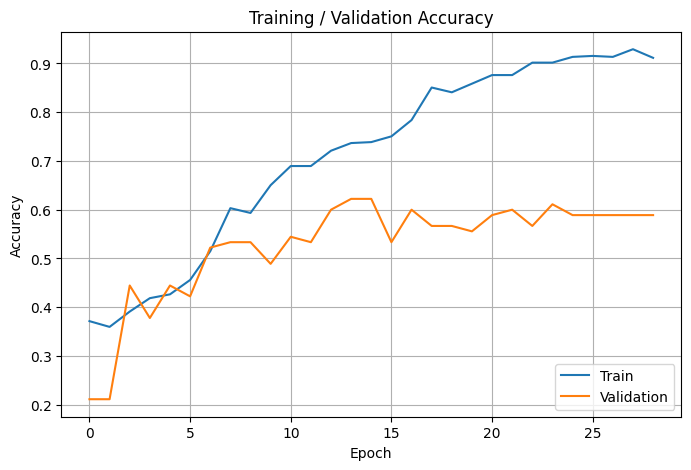

In [54]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    mode='max'
)

history = model.fit(
    X_train_pad,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.15,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)


plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title('Training / Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step
--------------------------------------------------
Test Accuracy: 0.580
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

         joy       0.62      0.55      0.58        51
        love       0.70      0.61      0.65        49
         sad       0.47      0.58      0.52        50

    accuracy                           0.58       150
   macro avg       0.60      0.58      0.58       150
weighted avg       0.60      0.58      0.58       150



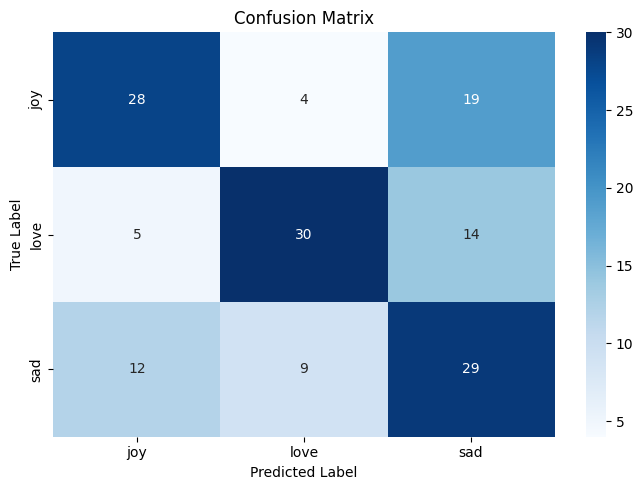

In [55]:
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

acc = accuracy_score(y_test, y_pred_classes)
print("-" * 50)
print(f"Test Accuracy: {acc:.3f}")
print("-" * 50)

emotion_names = ['joy', 'love', 'sad']

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=emotion_names))

plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()